## Required Libraries

In [408]:
import nltk
nltk.download('vader_lexicon')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91872\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [410]:
dataset = pd.read_csv("Sentiment.csv")
print(dataset.head(),"\n")
print("Dataset shape --->",dataset.shape)

                                               reply     label
0                           Can we discuss pricing??   NEUTRAL
1  Im excited to explore this further, plz send c...  POSITIVE
2                We not looking for new solutions.    negative
3                 Could u clarify features included?   neutral
4           lets,, schedule a meeting to dive deeper  positive 

Dataset shape ---> (2129, 2)


## Information of the dataset

In [412]:
# Display dataset overview
print("\nDataset Overview:")
print(f"Total Rows: {dataset.shape[0]}, Total Columns: {dataset.shape[1]}")
print("\nDataset Information:")
dataset.info()


Dataset Overview:
Total Rows: 2129, Total Columns: 2

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reply   2129 non-null   object
 1   label   2129 non-null   object
dtypes: object(2)
memory usage: 33.4+ KB


## Basic EDA

In [414]:
dataset.isnull().sum()
dataset['label'].value_counts()

label
neutral     704
positive    446
NEGATIVE    267
POSITIVE    263
Negative    254
negative    189
Neutral       3
NEUTRAL       2
Positive      1
Name: count, dtype: int64

In [415]:
# Clean Labels

# We convert all labels to lowercase to avoid duplicates

dataset['label'] = dataset['label'].str.lower()
dataset['label'].value_counts()

label
positive    710
negative    710
neutral     709
Name: count, dtype: int64

## Text cleaning / preprocessing

In [417]:
def clean_text(s):
    if pd.isnull(s): return ""
    s = str(s).lower()        
    s = re.sub(r'[^a-z0-9\s]', ' ', s)       # keep letters/spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

dataset['text_clean'] = dataset['reply'].apply(clean_text)
dataset = dataset[dataset['text_clean'].str.len() > 0].copy()   # drop empty rows after cleaning
dataset

,reply,label,text_clean
0,Can we discuss pricing??,neutral,can we discuss pricing
1,"Im excited to explore this further, plz send c...",positive,im excited to explore this further plz send co...
2,We not looking for new solutions.,negative,we not looking for new solutions
3,Could u clarify features included?,neutral,could u clarify features included
4,"lets,, schedule a meeting to dive deeper",positive,lets schedule a meeting to dive deeper
...,...,...,...
2124,I’ll forward this to my manager.,neutral,i ll forward this to my manager
2125,Can you share more information?,neutral,can you share more information
2126,Send me the details and I’ll review.,neutral,send me the details and i ll review
2127,What exactly does your product do?,neutral,what exactly does your product do


In [418]:
# Sentiment Analysis using VADER
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
dataset['vader_score'] = dataset['text_clean'].apply(lambda x: sia.polarity_scores(x)['compound'])

## Visualizing Sentiment Distribution

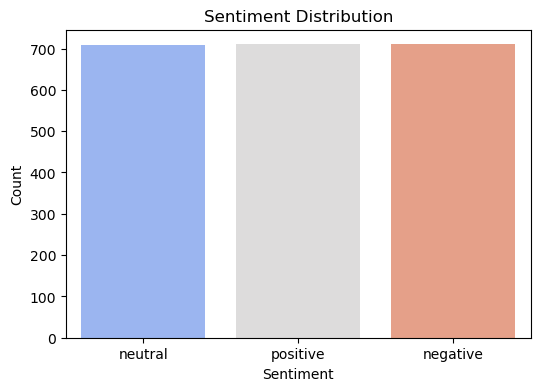

In [420]:
# Visualizing Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=dataset['label'], palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

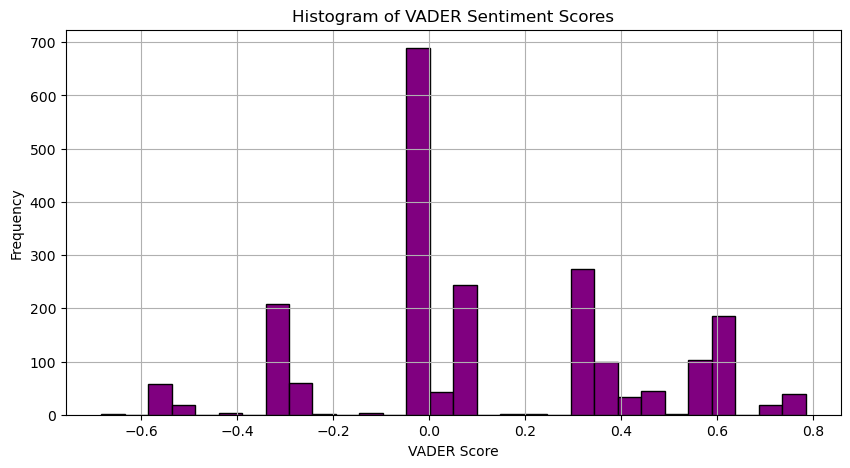

In [421]:
# Additional Visualizations
plt.figure(figsize=(10,5))
dataset['vader_score'].hist(bins=30, color='purple', edgecolor='black')
plt.title('Histogram of VADER Sentiment Scores')
plt.xlabel('VADER Score')
plt.ylabel('Frequency')
plt.show()

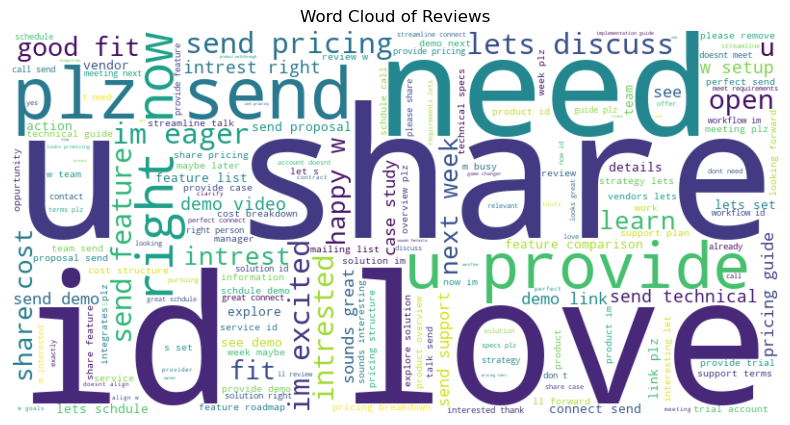

In [422]:
# Word Cloud Visualization

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(dataset['text_clean']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

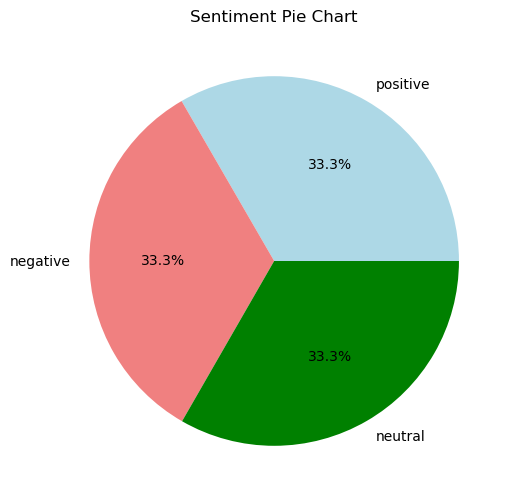

In [423]:
#Pie chart
plt.figure(figsize=(6,6))
dataset['label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue', 'lightcoral','green'])
plt.title('Sentiment Pie Chart')
plt.ylabel('')
plt.show()

## Label normalization / mapping

In [425]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
dataset['label_encoded'] = encoder.fit_transform(dataset['label'])
dataset

,reply,label,text_clean,vader_score,label_encoded
0,Can we discuss pricing??,neutral,can we discuss pricing,0.0000,1
1,"Im excited to explore this further, plz send c...",positive,im excited to explore this further plz send co...,0.4019,2
2,We not looking for new solutions.,negative,we not looking for new solutions,0.1779,0
3,Could u clarify features included?,neutral,could u clarify features included,0.0000,1
4,"lets,, schedule a meeting to dive deeper",positive,lets schedule a meeting to dive deeper,0.0000,2
...,...,...,...,...,...
2124,I’ll forward this to my manager.,neutral,i ll forward this to my manager,0.0000,1
2125,Can you share more information?,neutral,can you share more information,0.2960,1
2126,Send me the details and I’ll review.,neutral,send me the details and i ll review,0.0000,1
2127,What exactly does your product do?,neutral,what exactly does your product do,0.0000,1


## Text Vectorization

In [427]:
X = dataset['text_clean']
y = dataset['label']

In [428]:
# Convert text → TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

## Train / test split (stratified)

In [430]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [431]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X_count = vectorizer.fit_transform(X)


In [432]:
# Vectorize text
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

## Defining and Training the models

In [434]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'SVM': SVC(probability=True, kernel='linear')
}

# Dictionary to store results
model_results = {}

# Train & Evaluate
for name, model in models.items():
    print(f'\nTraining {name}...')
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    model_results[name] = accuracy
    print(f'{name} Accuracy: {accuracy:.4f}')


Training Naive Bayes...
Naive Bayes Accuracy: 0.9953

Training Logistic Regression...
Logistic Regression Accuracy: 0.9977

Training Random Forest...
Random Forest Accuracy: 0.9930

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.9977

Training SVM...
SVM Accuracy: 0.9953


In [435]:
# Model Performance Summary
print("Model Performance Summary:")
for model_name, acc in sorted(model_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name}: Accuracy = {acc:.4f}")

# Best Model Selection
best_model = max(model_results, key=model_results.get)
print(f"Best Performing Model: {best_model} with Accuracy = {model_results[best_model]:.4f}")


Model Performance Summary:
Logistic Regression: Accuracy = 0.9977
Gradient Boosting: Accuracy = 0.9977
Naive Bayes: Accuracy = 0.9953
SVM: Accuracy = 0.9953
Random Forest: Accuracy = 0.9930
Best Performing Model: Logistic Regression with Accuracy = 0.9977


## Evaluation

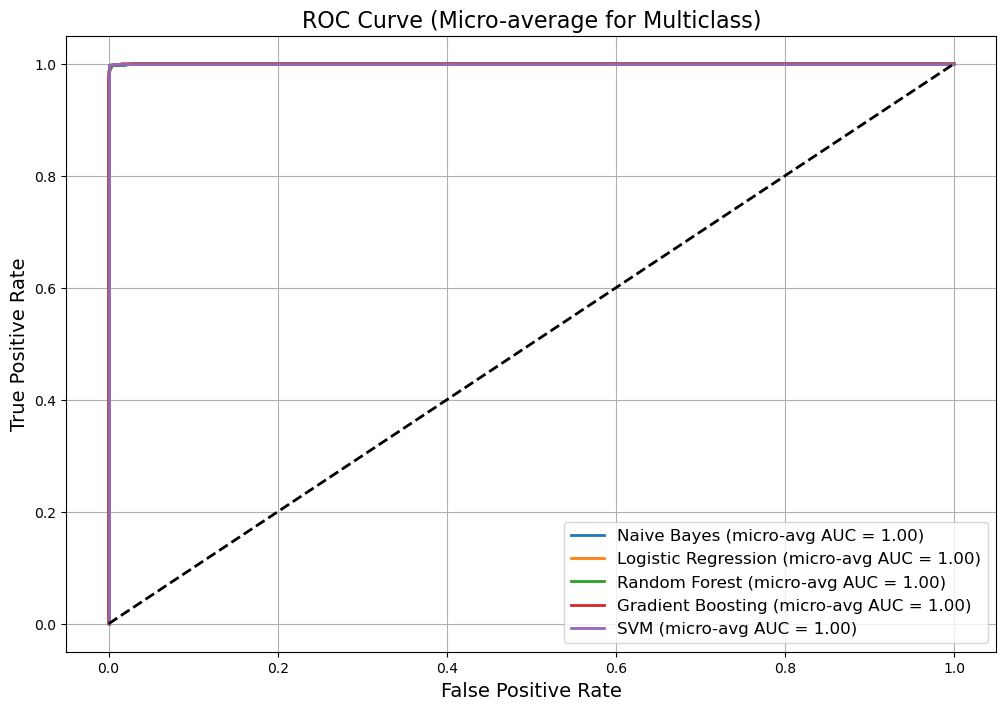

In [437]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(12, 8))   # 🔥 bigger figure

for name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)

    # Micro-average ROC
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (micro-avg AUC = {auc(fpr, tpr):.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve (Micro-average for Multiclass)", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()


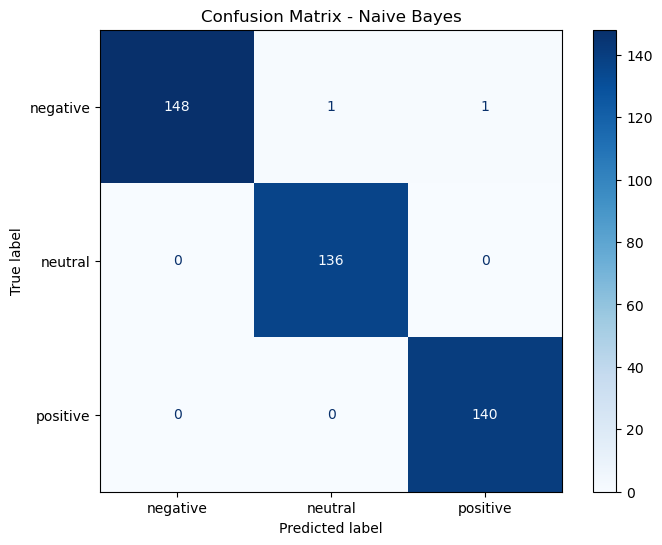

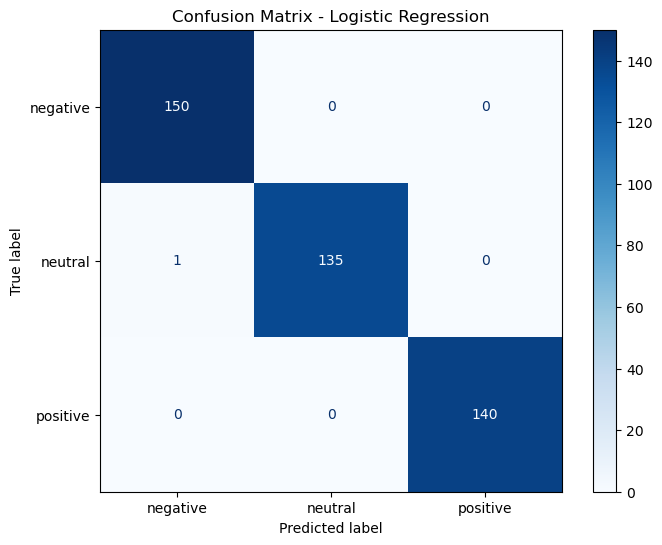

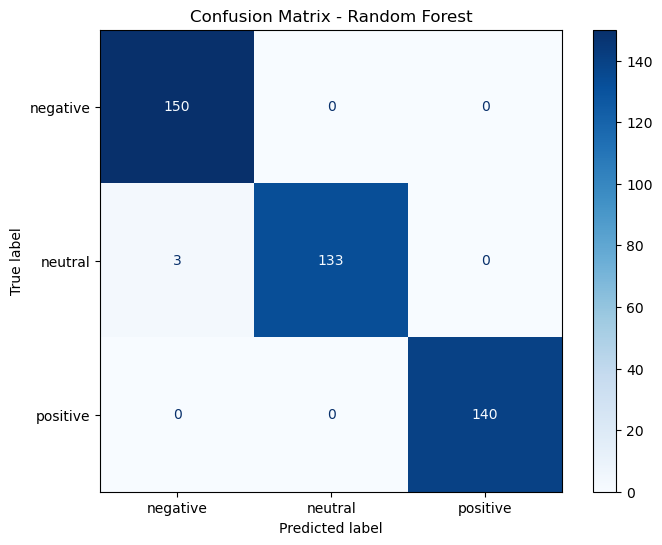

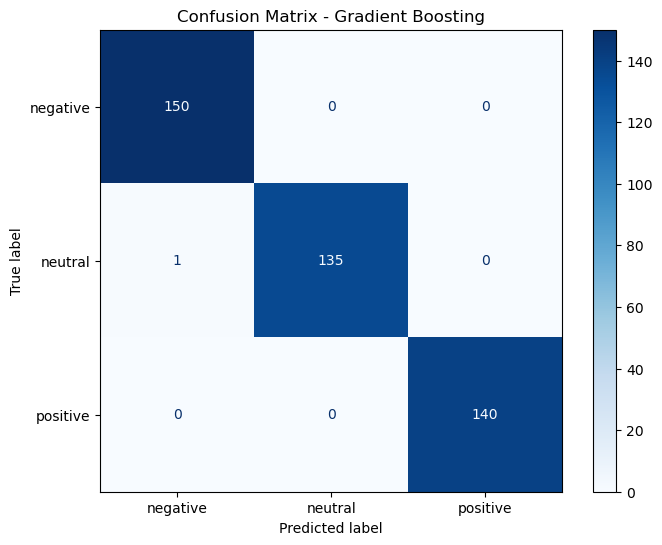

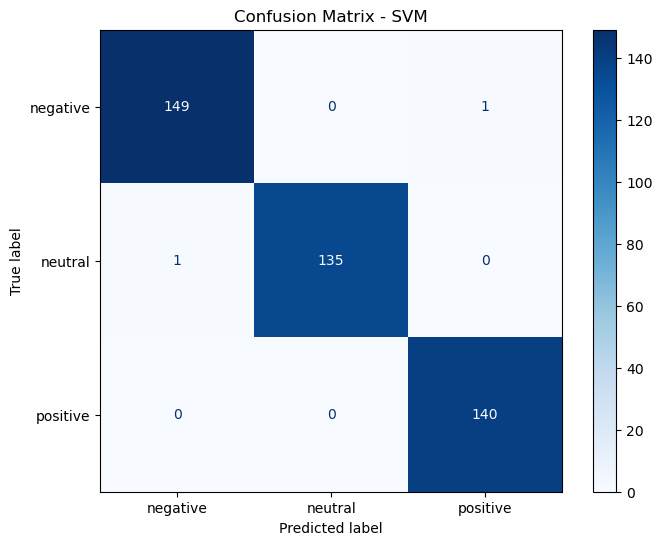

In [438]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

    plt.figure(figsize=(8, 6))   # 🔥 bigger size
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


## Baseline pipeline: TF-IDF + Logistic Regression

In [440]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# X_train and X_test must be raw text
# y_train and y_test are labels

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, stop_words='english')),
    ("clf", LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train1, y_train1)          # fit on raw text
y_pred = pipeline.predict(X_test1)       # predict

accuracy = accuracy_score(y_test1, y_pred)
print(f"Pipeline Accuracy: {accuracy:.4f}")


Pipeline Accuracy: 0.9953


## Evaluation

In [443]:
y_pred = pipeline.predict(X_test1)
accuracy_score(y_test1, y_pred)    
f1_score(y_test1, y_pred, average='macro') 
print(classification_report(y_test1, y_pred))

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99       150
     neutral       1.00      0.99      1.00       136
    positive       0.99      1.00      1.00       140

    accuracy                           1.00       426
   macro avg       1.00      1.00      1.00       426
weighted avg       1.00      1.00      1.00       426



### Check for duplicates

In [446]:
# count duplicates
duplicates = dataset.duplicated(subset=['text_clean']).sum()
print("Number of duplicate texts:", duplicates)

# see the actual duplicate rows
dataset[dataset.duplicated(subset=['text_clean'], keep=False)]


Number of duplicate texts: 1812


,reply,label,text_clean,vader_score,label_encoded
26,Not in market for this,negative,not in market for this,0.0000,0
34,Can u share demo video?,neutral,can u share demo video,0.2960,1
41,Doesnt align w/ goals,negative,doesnt align w goals,0.0000,0
54,Id love to explore further!,positive,id love to explore further,0.6369,2
58,Plz send pricing structure,neutral,plz send pricing structure,0.0772,1
...,...,...,...,...,...
2124,I’ll forward this to my manager.,neutral,i ll forward this to my manager,0.0000,1
2125,Can you share more information?,neutral,can you share more information,0.2960,1
2126,Send me the details and I’ll review.,neutral,send me the details and i ll review,0.0000,1
2127,What exactly does your product do?,neutral,what exactly does your product do,0.0000,1


### Check train/test overlap

In [451]:
overlap = set(X_train1).intersection(set(X_test1))
print("Number of overlapping texts:", len(overlap))

Number of overlapping texts: 107


### Check if label word appears inside text

In [454]:
for lbl in dataset['label'].unique():   # use original label column
    count = dataset[dataset['text_clean'].str.contains(lbl, case=False)]['text_clean'].shape[0]
    print(f"Label '{lbl}' appears in {count} texts")


Label 'neutral' appears in 0 texts
Label 'positive' appears in 0 texts
Label 'negative' appears in 0 texts


In [457]:
import joblib, os
os.makedirs("/mnt/data/models_reply_classifier", exist_ok=True)
joblib.dump(pipeline, "/mnt/data/models_reply_classifier/baseline_logreg_tfidf.joblib")


['/mnt/data/models_reply_classifier/baseline_logreg_tfidf.joblib']

In [460]:
## Example

In [462]:
import joblib
model = joblib.load("/mnt/data/models_reply_classifier/baseline_logreg_tfidf.joblib")
text = "Looking forward to the demo!"
pred = model.predict([text])[0]
proba = model.predict_proba([text])[0].max()   # model must support predict_proba
print(pred, float(proba))


positive 0.69117907681213
